# ENSf 611 Project - Housing Data Regression

Sam Rainbow (UCID 30084292)

### 1. Load and Analyze data

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

One interesting thing to note is that for Kaggle competitions the data is split into training and testing before hand and the testing set does not contain the target variable. This is because you submit the predictions for the testing set to Kaggle and they compare it to the actual values to determine the score. Because of this I will have to work on each data set separately.

In [30]:
# Load the training and testing data
df_train = pd.read_csv('train.csv', na_values = 'NA')
df_test = pd.read_csv('test.csv', na_values = 'NA')

# Print the first 5 rows of the training data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [31]:
# Lets look at the potential features in the data set.
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [32]:
# Compare the number of columns in training and testing
print('Number of columns in training set: ', len(df_train.columns))
print('Number of columns in testing set: ', len(df_test.columns))

# Lets find the which column is is the training set but not in the testing set
print('Column in training set but not in testing set: ', set(df_train.columns) - set(df_test.columns))


Number of columns in training set:  81
Number of columns in testing set:  80
Column in training set but not in testing set:  {'SalePrice'}


In [33]:
# Lets drop the ID column as it is not needed for the analysis and we know it should not have any impact on the sale price.
df_train.drop('Id', axis = 1, inplace = True)
df_test.drop('Id', axis = 1, inplace = True)

In [34]:
# Inspect the predicted label of the training set
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The data appears to not have any major outliers in the predicted label with a max of 755k and min of 35k.

<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

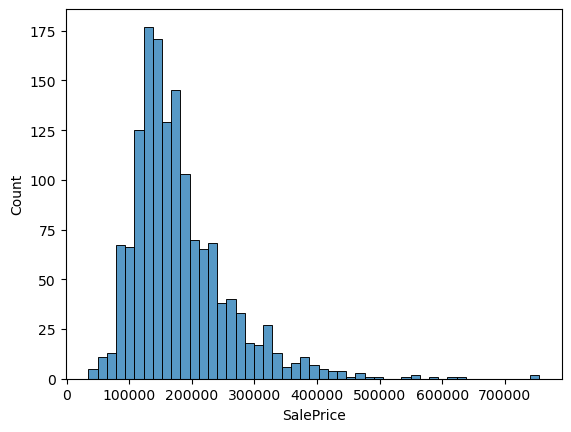

In [35]:
# Lets look at the distribution of the predicted label
sns.histplot(df_train['SalePrice'])

C:\Users\sammr\AppData\Local\Temp\ipykernel_23244\3045151586.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train.corr()


<AxesSubplot: >

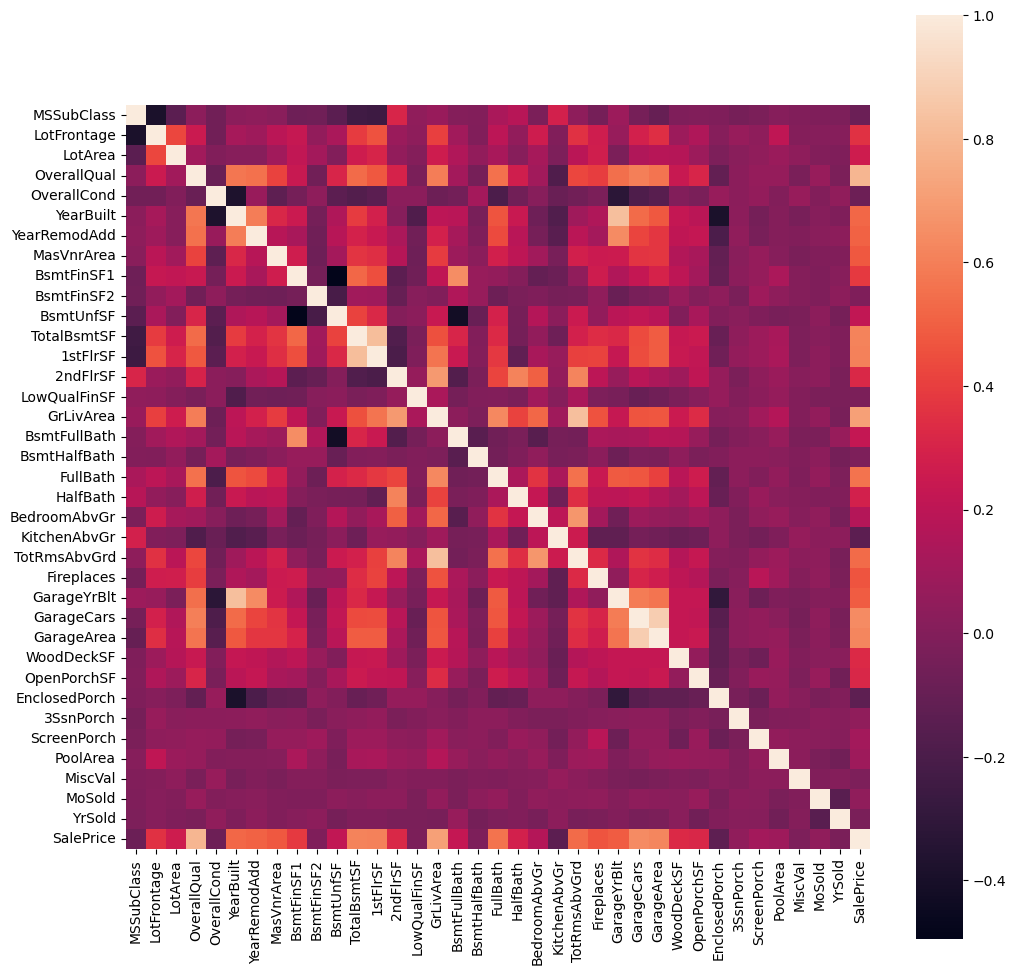

In [36]:
#Lets see which quantitative features are correlated with the predicted label using a correlation matrix.
corr_matrix = df_train.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_matrix, square=True)

We can see above that in the bottom row representing Sale Price (target variabel) that OverallQuality, Gross Living Area, GarageArea, and GarageCars seem to be strongly correlated with saleprice and could indicate potential features that will be useful in our model.
Lets look a little closer at the top 10 features.

C:\Users\sammr\AppData\Local\Temp\ipykernel_23244\498545658.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train.corr()


<AxesSubplot: >

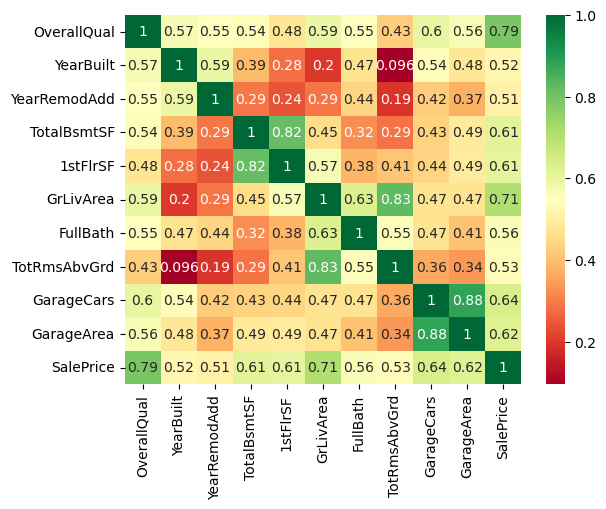

In [37]:
# Create a correlation matrix with the top features correlated with the predicted label with higher than 0.5.
corr_matrix = df_train.corr()
top = corr_matrix.index[(abs(corr_matrix['SalePrice']) > 0.5)]
sns.heatmap(df_train[top].corr(), annot=True, cmap="RdYlGn")

Again here we can see the correlation between the target variable and the top 10 features with overall quality's correlation being ~82% and GrossLivingArea at 70%.

### Dealing with missing values

Below we will view, analyze and deal with any missing values in the data. First we will combine the training and testing data set from Kaggle into one data set so that we can deal with the missing values together and accurately since we will be replacing values with the mean of the column for quantitative variables and mode for categorical variables.

In [38]:
# Combine the training and testing data for feature engineering and dealing with missing values.
df = pd.concat([df_train, df_test], axis = 0, ignore_index = True)
df.shape

(2919, 80)

In [40]:
# Lets look at the missing values in the data set with more than 1 missing value.
df.isnull().sum()[df.isnull().sum() > 1].sort_values(ascending = False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
dtype: int64

In [39]:
# In the training set lets find the number of missing values in each column and sort them in descending order by number of missing values. Only show columns with 1 or more missing values.
missing_values_train = df_train.isnull().sum().sort_values(ascending=False)
missing_values_train = missing_values_train[missing_values_train > 0]
missing_values_train

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [ ]:
# Lets check for missing values in the testing set
missing_values_test = df_test.isnull().sum().sort_values(ascending=False)
missing_values_test = missing_values_test[missing_values_test > 0]
missing_values_test

Looking at columns with missing values we can easily remove ones with large amounts of missing data. We will remove the following columns: PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage since they all have a large portion of data missing. Furthermore, we will replace null values for all garage descriptions as it is likely this means the house does not have a garage, and similar for basement. For any null values in remaining columns will be filled with the mean value of the column if quantitive or the mode if categorical.

In [ ]:
# Remove columns PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage from both data sets.
df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], axis = 1, inplace = True)
df_test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage'], axis = 1, inplace = True)

# Replace values in GarageType, GarageFinish, GarageQual, GarageCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 with "None".
col_to_replace = ['GarageYrBlt','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] 
for col in col_to_replace:
    df_train[col].fillna('None', inplace = True)
    df_test[col].fillna('None', inplace = True)


After analyzing the data description from Kaggle https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data we can see that there are some columns that should not be quantitative. For example, MSSubClass is a value between 20 and 100 that represnts the classification of the building. For example 20 represents "1-STORY 1946 & NEWER ALL STYLES" this is a categorical variable and should not be treated as a quantitative variable. We will convert these to categorical variables.

Additonally we will treat: MoSold, YrSold as categorical variables.

This needs to be done before we deal with missing values.

In [ ]:
# Convert the quantitative features to categorical features listed above (MSSubClass, MoSold, YrSold, and GarageYrBlt)
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['MoSold'] = df_train['MoSold'].apply(str)
df_train['YrSold'] = df_train['YrSold'].apply(str)
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].apply(str)


# Same for the testing set
df_test['MSSubClass'] = df_test['MSSubClass'].apply(str)
df_test['MoSold'] = df_test['MoSold'].apply(str)
df_test['YrSold'] = df_test['YrSold'].apply(str)
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].apply(str)

In [ ]:
# Remove columns with more than 10 rows of the data missing in either set from both sets.

# First we will update the columns with missing values since we corrected some of them above.
missing_values_train = df_train.isnull().sum().sort_values(ascending=False)
missing_values_train = missing_values_train[missing_values_train > 0]

missing_values_test = df_test.isnull().sum().sort_values(ascending=False)
missing_values_test = missing_values_test[missing_values_test > 0]


# Create a list of columns to drop.
columns_to_drop = list(missing_values_train[missing_values_train > 10].index)
columns_to_drop.extend(list(missing_values_test[missing_values_test > 10].index))

# Drop the columns from both sets
df_train.drop(columns_to_drop, axis = 1, inplace = True)
df_test.drop(columns_to_drop, axis = 1, inplace = True)

In [ ]:
# Show the columns that are missing values in the training set
missing_values_train = df_train.isnull().sum().sort_values(ascending=False)
missing_values_train = missing_values_train[missing_values_train > 0]
missing_values_train

In [ ]:
# Show the columns that are missing values in the testing set
missing_values_test = df_test.isnull().sum().sort_values(ascending=False)
missing_values_test = missing_values_test[missing_values_test > 0]
missing_values_test

### Now I will deal with the remaining missing values that will be replaced by the average value of the column if quantitative or the most common value if categorical.

#### Note that the Kaggle data set is already split prior to downloading and as such I have and will continue to process the set independently.

In [ ]:
# Determine which columns are categorical and which are quantitative for training
categorical_columns = df_train.select_dtypes(include=['object']).columns
quantitative_columns = df_train.select_dtypes(exclude=['object']).columns

# Determine which columns are quantitative for testing set. This will be different than above since the testing set does not have sale price.
quantitative_columns_test = df_test.select_dtypes(exclude=['object']).columns

# If a missing value is in a categorical column, replace it with the most common value in that column.
for column in categorical_columns:
    df_train[column].fillna(df_train[column].mode()[0], inplace = True)
    df_test[column].fillna(df_test[column].mode()[0], inplace = True)

# If a missing value is in a quantitative column, replace it with the mean value in that column.
for column in quantitative_columns:
    df_train[column].fillna(df_train[column].mean(), inplace = True)

# Sale price does not exist in the testing set but is the target variable so the quantitive columns are different than the training set.
for column in quantitative_columns_test:
    df_test[column].fillna(df_test[column].mean(), inplace = True)


In [ ]:
# Check to make sure there are no null values in both sets and print the number of rows and columns in each set
print('Number of rows and columns in training set: ', df_train.shape)
print('Number of rows and columns in testing set: ', df_test.shape)
print('Number of null values in training set: ', df_train.isnull().sum().sum())
print('Number of null values in testing set: ', df_test.isnull().sum().sum())

It appears that the the number of columns is correct since the training set has one extra column for sale price (target variable)

In [ ]:
# Print the dirrerence between the columns in the training and testing set
print('Columns in training set but not in testing set: ', set(df_train.columns) - set(df_test.columns))


### Lets continue to analyze more of the training set

In [ ]:
# Lets use a pairplot to see the distribution of the data in each column for the top 10 features correlated with the predicted label.

corr_matrix = df_train.corr()
top = corr_matrix.index[(abs(corr_matrix['SalePrice']) > 0.5)]

sns.pairplot(df_train[top[0:11]], height = 2.5)


Above we can see the correlations visualized in pairing plots. We can see that the top 10 features are all strongly correlated with each sale price and eachother indicating a positive characteristic of the data for linear regression.

### Feature Enginering

In [ ]:
# Lets again look at the features and separate into categorical and quantitative features.
# Print the number of categorical and quantitative features.
print('There are {} categorical features:'.format(len(categorical_columns)))
print(categorical_columns)
print('There are {} quantitative features:'.format(len(quantitative_columns)))
print(quantitative_columns)

In [ ]:
# print the columns in training and testing set
print('Columns in training set: ', df_train.columns)
print('Columns in testing set: ', df_test.columns)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Reset the column types after converting quantitative features to categorical features.
categorical_columns = df_train.select_dtypes(include=['object']).columns
quantitative_columns = df_train.select_dtypes(exclude=['object']).columns

# Use one hot encoder to encode the categorical features in both the training set and testing set.
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(df_train[categorical_columns])
df_train_encoded = encoder.transform(df_train[categorical_columns])
df_test_encoded = encoder.transform(df_test[categorical_columns])

In [ ]:
# The line of code below creates a new dataframe with the one hot encoded features. We need to add the quantitative features to this dataframe for both sets
df_train_encoded = pd.DataFrame(df_train_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_test_encoded = pd.DataFrame(df_test_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Add the quantitative features to the encoded dataframes
df_train_encoded = pd.concat([df_train_encoded, df_train[quantitative_columns]], axis=1)
df_test_encoded = pd.concat([df_test_encoded, df_test[quantitative_columns_test]], axis=1)

# Print the number of rows and columns in each set
print('Number of rows and columns in training set: ', df_train_encoded.shape)
print('Number of rows and columns in testing set: ', df_test_encoded.shape)

# Print the difference between the columns in the training and testing set
print('Columns in training set but not in testing set: ', set(df_train_encoded.columns) - set(df_test_encoded.columns))

In [ ]:
# Lets check the features and see the ranges between the features and determine if scaling is necessary. Showw all columns

pd.set_option('display.max_columns', None)
df_train_encoded.describe()

We can see that most of the features are cateogrical with a range of 0 to 1. While the quantitive can range into the 100000's. We will need to normalize the data to ensure that the model is not biased towards the quantitive features.

In [ ]:
# First I will remove the target variable from the training set since we do not want to scale it
df_train_encoded.drop('SalePrice', axis=1, inplace=True)

In [ ]:
# Lets normalize the data using the StandardScaler
from sklearn.preprocessing import StandardScaler

# Fit the scaler to the training set
scaler = StandardScaler()
scaler.fit(df_train_encoded)

# I only want to scale the features and not the target variable in the training set
df_train_scaled = scaler.transform(df_train_encoded)

# We will also scaled the testing set
df_test_scaled = scaler.transform(df_test_encoded)

In [ ]:
# Split the training set into a training set and a validation set.
from sklearn.model_selection import train_test_split

X = df_train_scaled
y = df_train['SalePrice']

# Use the train_test_split function to split the training set into a training set and a validation set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 2 Choose a model

In [ ]:
# Import three ML models LinearRegression, RandomForestRegressor, and GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

### Step 3: Instantiate model and select hyperparameters

In [ ]:
from sklearn.model_selection import cross_validate
# Define a function to calcaulate the mean training and validation score for a regressor using cross-validation. This function is from my ENSF course Lab 2 assignment.

def get_regressor_neg_rms(model, X, y, cv=7):
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms)
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    
    #TODO: add function body here
    rms = cross_validate(model, X, y, cv=cv, scoring='neg_root_mean_squared_error', return_train_score=True)
    rms_train = rms['train_score'].mean()
    rms_val = rms['test_score'].mean()

    return rms_train, rms_val

In [ ]:
# Create a list of the models
models = [LinearRegression(), RandomForestRegressor(), GradientBoostingRegressor(), xgb.XGBRegressor(objective='reg:squarederror')]

# Loop through the models and print the training and validation score for each model
for model in models:
    train_score, val_score = get_regressor_neg_rms(model, X_train, y_train, cv=7)
    print(f"{type(model).__name__}: \n  Training score: {train_score:.2f}\n  Validation score: {val_score:.2f}")

In [ ]:
# Plot the actual sale price vs the predicted sale price for the training set for each model
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    plt.scatter(y_train, y_pred, label=type(model).__name__)
    plt.xlabel('Actual Sale Price')
    plt.ylabel('Predicted Sale Price')
    plt.legend()
    plt.show()
    

Above we can visualize the variance between the actual sale price vs the predicted sale price on the training set. Of the four models it appears that XGBRegressor has the lowest variance and is the best model for this data set.

Lets tune the hyperparameters of the XGBRegressor model.

### Step 4: Fit the model to data

In [ ]:
# Rename the data to X and the predicted label to y.
# X = data_enc
# y = df_train['SalePrice']

# Fit the model to the data.
model.fit(X_train, y_train)


### Step 5: Predict the SalePrice for the test data set.

In [ ]:
# Create and export a csv file with the predicted values for the test set
y_pred = model.predict(df_test_encoded)
df_pred = pd.DataFrame(y_pred, columns=['SalePrice'])

#Convert df_pred back from a log scale to a normal scale
df_pred['SalePrice'] = np.exp(df_pred['SalePrice'])

df_test2 = pd.read_csv('test.csv', na_values = 'NA')

# Add the ID column to the dataframe before the saleprice column
df_pred.insert(0, 'Id', df_test2['Id'])

df_pred.to_csv('submission.csv', index=False)